In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential, load_model
from keras.layers import LSTM, Dropout, Dense, Activation
from keras.callbacks import ModelCheckpoint, TerminateOnNaN
from keras.optimizers import RMSprop

from decimal import Decimal

## Load the data we created in data_read_and_process.ipynb

In [2]:
X_train = np.load('../train_and_val/X_train.npy')
X_val = np.load('../train_and_val/X_val.npy')
y_train = np.load('../train_and_val/y_train.npy')
y_val = np.load('../train_and_val/y_val.npy')

## Build a Model

In [3]:
def lstm(n_lstm_layers = 2, n_dense_layers = 1, n_lstm_nodes = 512, dropout_rate = 0.4):
    """Generate a keras Sequential model of the form as described in Figure 16 of
    https://www.tandfonline.com/doi/full/10.1080/25765299.2019.1649972"""
    model = Sequential()
    model.add(LSTM(n_lstm_nodes, return_sequences = True, input_shape = (16, 89,)))
    model.add(Dropout(dropout_rate))
    for i in range(1, n_lstm_layers - 1):
        model.add(LSTM(n_lstm_nodes, return_sequences = True))
        model.add(Dropout(dropout_rate))
    model.add(LSTM(n_lstm_nodes))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_lstm_nodes // 2))
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))
    for i in range(n_dense_layers - 1):
        model.add(Dense(n_lstm_nodes // 2))
        model.add(Dropout(0.6))
    model.add(Dense(89))
    model.add(Activation('sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'RMSProp')
    return model

## Custom Loss and Metrics

\begin{equation*}
bce\_loss = \frac{1}{N} (\sum_{i=1}^{N} y_i log(p(y_i)) + (1 - y_i) log(1 - p(y_i)))
\end{equation*}
\begin{equation*}
maestro\_loss = 2 * Harshness \lvert\frac{d_{true} - d_{pred}}{d_{true} + d{_{pred}}}\rvert
\end{equation*}
<br>
\begin{equation*}
total\_loss = MIN(2 * bce\_loss, bce\_loss + maestro\_loss)
\end{equation*}

where N = num_keys_piano, <b>Harshness</b> is a constant to be determined, and <b>d</b> gives the normalized duration. I'll call it the <b>Maestro Loss Function</b> since it pays special attention to the timing of the notes. It is usually composed of a Binary Cross Entropy Term with an additional term proportional to the relative error in duration between $d_{true}$ and $d_{pred}$. However, we limit the total_loss to be less than twice the bce_loss. We also define custom metrics, read the docstrings for their descriptions.

In [9]:
import keras.backend as K
import tensorflow as tf

def maestro_loss_wr(harshness): 
    """A loss function which, in addition to penalizing for misclassification on the 
    first n_keys_piano elements, includes a term proportional to the relative
    error in the prediction of the last element (which repesents the duration). 
    The proportionality constant is the 'harshness' of the maestro in regards to
    timing."""
    def maestro_loss(ytrue, ypred):
        # Standard binary cross-entropy
        bce_loss = - K.mean(ytrue[:, :-1] * K.log(ypred[:, :-1]) + (1 - ytrue[:, :-1]) * \
                     K.log(1 - ypred[:, :-1]))

        # Duration error term
        dur_loss = 2 * harshness * K.mean(K.abs((ytrue[:, -1] - ypred[:, -1]) / \
                                      (ytrue[:, -1] + ypred[:, -1] + K.epsilon())))
        
        if (dur_loss > bce_loss):   # Often times, ytrue[:, -1] elements will be zero
            return bce_loss * 2     # This may spike dur_loss. To control, I limit it
                                    # so that it never exceeds the bce_loss.
        return bce_loss + dur_loss
    
    return maestro_loss

def precision_mod(ytrue, ypred):
    """Just a modified precision excluding the last element (which is not a classification)"""

    true_positives = K.sum(K.round(ytrue[:, :-1] * ypred[:, :-1]))
    pred_positives = K.sum(K.round(ypred[:, :-1]))
    return true_positives / (pred_positives + K.epsilon())

def recall_mod(ytrue, ypred):
    """Just a modified recall excluding the last element (which is not a classification)"""

    true_positives = K.sum(K.round(ytrue[:, :-1] * ypred[:, :-1]))
    poss_positives = K.sum(ytrue[:, :-1])
    return true_positives / (poss_positives + K.epsilon())

def f1_score_mod(ytrue, ypred):
    """Just a modified f1_score excluding the last element (which is not a classification)"""

    precision = precision_mod(ytrue, ypred)
    recall = recall_mod(ytrue, ypred)   
    return 2 * (precision * recall) / (precision + recall + K.epsilon())

def dur_error(ytrue, ypred):
    """A new metric that only gives information on the error in duration predictions"""
    
    return 2 * K.mean(K.abs((ytrue[:, -1] - ypred[:, -1]) / (ytrue[:, -1] + ypred[:, -1] + \
                                                         K.epsilon())))

def maestro_dur_loss_wr(harshness):
    """The second term of the maestro loss, based purely on error in duration predictions.
    To be used as a metric in order to decompose the loss components during analysis"""
    def maestro_dur_loss(ytrue, ypred):

        return 2 * harshness * K.mean(K.abs((ytrue[:, -1] - ypred[:, -1]) / \
                                      (ytrue[:, -1] + ypred[:, -1] + K.epsilon())))
    return maestro_dur_loss

In [10]:
def generate_cols_dict(history):
    """return a mapping of desired column names to the corresponding columns in the
    history dictionary (previously history.history where history is the return value
    of model.train)"""
    return {'maestro_loss': history['loss'], 'f1_score': history['f1_score_mod'], \
 'precision': history['precision_mod'], 'recall': history['recall_mod'], \
 'dur_error': history['dur_error'], 'dur_loss': history['maestro_dur_loss'], \
 'val_maestro_loss': history['val_loss'], 'val_f1_score': history['val_f1_score_mod'], \
 'val_precision': history['val_precision_mod'], 'val_recall': history['val_recall_mod'], \
 'val_dur_error': history['val_dur_error'], 'val_dur_loss': history['val_maestro_dur_loss']}

## Training

Let's begin with a similar model to [this paper](https://www.tandfonline.com/doi/full/10.1080/25765299.2019.1649972). To save time, let us use 2 LSTM layers and 1 Dense layer instead of (4 and 3 as in the paper) 

In [11]:
def train_lstm_model(n_lstm_layers = 2, n_dense_layers = 1, n_lstm_nodes = 512, dropout_rate = 0.4, \
                     batch_size = 512, harshness = 0.05, lr = None, clipnorm = None, clipvalue = None, \
                     epochs = 150):
    """Train a model using the passed parameters, the data, and using the RMSprop optimizer. Write the
    best model as a .h5 and a .csv containing columns for the training and validation custom loss and
    metrics. Returns nothing."""
    model = lstm(n_lstm_layers = n_lstm_layers, n_dense_layers = n_dense_layers, \
                 n_lstm_nodes = n_lstm_nodes, dropout_rate = dropout_rate)

    if (lr or clipnorm or clipvalue):
        if (lr):          # It's required that the first argument to RMSprop is not None
            opt = RMSprop(lr = lr, clipnorm = clipnorm, clipvalue = clipvalue)
        elif (clipnorm):
            opt = RMSprop(clipnorm = clipnorm, clipvalue = clipvalue)
        else: # clipvalue
            opt = RMSprop(clipvalue = clipvalue)
    else:
        opt = RMSprop()   # TypeError when all are None, so do this instead
        
    model.compile(loss = maestro_loss_wr(harshness), optimizer = opt, metrics = [f1_score_mod, recall_mod, \
                                                precision_mod, dur_error, maestro_dur_loss_wr(harshness)])
    
    filename = 'best_maestro_model_{0}_{1}_{2}_{3}'.format(n_lstm_layers, n_dense_layers, n_lstm_nodes, \
                                                          str(dropout_rate).replace('.', 'pt'))
    if (lr):
        filename += '_lr_{}'.format('%.0e' % Decimal(lr))
    if (clipnorm):
        filename += '_cn_{}'.format(str(clipnorm).replace('.', 'pt'))     
    if (clipvalue):
        filename += '_cv_{}'.format(str(clipvalue).replace('.', 'pt'))
                                   
    mc = ModelCheckpoint('../models/' + filename + '.h5', monitor = 'val_loss', mode = 'min', \
                                                         save_best_only = True, verbose = 1)
                                   
    history = model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, \
                    validation_data = (X_val, y_val), verbose = 2, callbacks = [mc, TerminateOnNaN()])
    
    # In most preliminary tests model training has failed at some point when the loss becomes NaN during
    # validation
    if (len(history.history['val_loss']) < len(history.history['loss'])):  # a NaN during training
        for key, value in history.history.items():
            if (key[:3] == 'val'):          # pd.DataFrame requires value lengths to be equal
                value.append(np.nan)
                
    df = pd.DataFrame(generate_cols_dict(history.history))
    df.index.name = 'Epochs'
    df.to_csv('../model_data/' + filename + '.csv')

In [12]:
train_lstm_model()

Epoch 1/150

Epoch 00001: val_loss improved from inf to 0.16027, saving model to ../models/best_maestro_model_2_1_512_0pt4.h5
50/50 - 144s - loss: 0.2178 - f1_score_mod: 0.0147 - recall_mod: 0.0239 - precision_mod: 0.0973 - dur_error: 1.0027 - maestro_dur_loss: 0.0501 - val_loss: 0.1603 - val_f1_score_mod: 0.0000e+00 - val_recall_mod: 0.0000e+00 - val_precision_mod: 0.0000e+00 - val_dur_error: 0.7351 - val_maestro_dur_loss: 0.0368
Epoch 2/150

Epoch 00002: val_loss improved from 0.16027 to 0.14367, saving model to ../models/best_maestro_model_2_1_512_0pt4.h5
50/50 - 139s - loss: 0.1623 - f1_score_mod: 0.0012 - recall_mod: 6.0225e-04 - precision_mod: 0.1845 - dur_error: 0.7081 - maestro_dur_loss: 0.0354 - val_loss: 0.1437 - val_f1_score_mod: 0.0000e+00 - val_recall_mod: 0.0000e+00 - val_precision_mod: 0.0000e+00 - val_dur_error: 0.5956 - val_maestro_dur_loss: 0.0298
Epoch 3/150

Epoch 00003: val_loss improved from 0.14367 to 0.13357, saving model to ../models/best_maestro_model_2_1_512_

Epoch 22/150

Epoch 00022: val_loss did not improve from 0.10794
50/50 - 132s - loss: 0.1166 - f1_score_mod: 0.2445 - recall_mod: 0.1483 - precision_mod: 0.7097 - dur_error: 0.4476 - maestro_dur_loss: 0.0224 - val_loss: 0.1109 - val_f1_score_mod: 0.2456 - val_recall_mod: 0.1484 - val_precision_mod: 0.7209 - val_dur_error: 0.3960 - val_maestro_dur_loss: 0.0198
Epoch 23/150

Epoch 00023: val_loss did not improve from 0.10794
50/50 - 133s - loss: 0.1163 - f1_score_mod: 0.2509 - recall_mod: 0.1524 - precision_mod: 0.7178 - dur_error: 0.4463 - maestro_dur_loss: 0.0223 - val_loss: 0.1159 - val_f1_score_mod: 0.2710 - val_recall_mod: 0.1697 - val_precision_mod: 0.6842 - val_dur_error: 0.4873 - val_maestro_dur_loss: 0.0244
Epoch 24/150

Epoch 00024: val_loss did not improve from 0.10794
50/50 - 133s - loss: 0.1156 - f1_score_mod: 0.2587 - recall_mod: 0.1582 - precision_mod: 0.7175 - dur_error: 0.4444 - maestro_dur_loss: 0.0222 - val_loss: 0.1138 - val_f1_score_mod: 0.2740 - val_recall_mod: 0.17

Epoch 44/150

Epoch 00044: val_loss did not improve from 0.09648
50/50 - 132s - loss: 0.0986 - f1_score_mod: 0.3880 - recall_mod: 0.2631 - precision_mod: 0.7420 - dur_error: 0.3807 - maestro_dur_loss: 0.0190 - val_loss: 0.0968 - val_f1_score_mod: 0.3539 - val_recall_mod: 0.2321 - val_precision_mod: 0.7494 - val_dur_error: 0.2912 - val_maestro_dur_loss: 0.0146
Epoch 45/150

Epoch 00045: val_loss improved from 0.09648 to 0.09494, saving model to ../models/best_maestro_model_2_1_512_0pt4.h5
50/50 - 131s - loss: 0.0978 - f1_score_mod: 0.3927 - recall_mod: 0.2674 - precision_mod: 0.7429 - dur_error: 0.3798 - maestro_dur_loss: 0.0190 - val_loss: 0.0949 - val_f1_score_mod: 0.3634 - val_recall_mod: 0.2417 - val_precision_mod: 0.7377 - val_dur_error: 0.2629 - val_maestro_dur_loss: 0.0131
Epoch 46/150
Batch 41: Invalid loss, terminating training
Batch 42: Invalid loss, terminating training
Batch 43: Invalid loss, terminating training
Batch 44: Invalid loss, terminating training
Batch 45: Invalid

We'll refer to the above model as the 'base_model'. Looks like we get a NaN loss while the model was still improving. This seems to be case of exploding gradients. To combat this, we can try lowering the learning rate as suggested [here](https://stackoverflow.com/questions/40050397/deep-learning-nan-loss-reasons).

In [13]:
train_lstm_model(lr = 0.0005)

Epoch 1/150

Epoch 00001: val_loss improved from inf to 0.14697, saving model to ../models/best_maestro_model_2_1_512_0pt4_lr_5e-04.h5
50/50 - 139s - loss: 0.2451 - f1_score_mod: 0.0284 - recall_mod: 0.0380 - precision_mod: 0.0799 - dur_error: 1.0205 - maestro_dur_loss: 0.0510 - val_loss: 0.1470 - val_f1_score_mod: 0.0000e+00 - val_recall_mod: 0.0000e+00 - val_precision_mod: 0.0000e+00 - val_dur_error: 0.5032 - val_maestro_dur_loss: 0.0252
Epoch 2/150

Epoch 00002: val_loss did not improve from 0.14697
50/50 - 144s - loss: 0.1690 - f1_score_mod: 0.0061 - recall_mod: 0.0031 - precision_mod: 0.1665 - dur_error: 0.7262 - maestro_dur_loss: 0.0363 - val_loss: 0.1497 - val_f1_score_mod: 0.0000e+00 - val_recall_mod: 0.0000e+00 - val_precision_mod: 0.0000e+00 - val_dur_error: 0.6078 - val_maestro_dur_loss: 0.0304
Epoch 3/150

Epoch 00003: val_loss improved from 0.14697 to 0.13265, saving model to ../models/best_maestro_model_2_1_512_0pt4_lr_5e-04.h5
50/50 - 166s - loss: 0.1562 - f1_score_mod: 

Epoch 22/150

Epoch 00022: val_loss did not improve from 0.11086
50/50 - 186s - loss: 0.1196 - f1_score_mod: 0.2136 - recall_mod: 0.1260 - precision_mod: 0.7094 - dur_error: 0.4412 - maestro_dur_loss: 0.0221 - val_loss: 0.1123 - val_f1_score_mod: 0.2055 - val_recall_mod: 0.1190 - val_precision_mod: 0.7627 - val_dur_error: 0.3789 - val_maestro_dur_loss: 0.0189
Epoch 23/150

Epoch 00023: val_loss improved from 0.11086 to 0.10807, saving model to ../models/best_maestro_model_2_1_512_0pt4_lr_5e-04.h5
50/50 - 187s - loss: 0.1185 - f1_score_mod: 0.2234 - recall_mod: 0.1329 - precision_mod: 0.7121 - dur_error: 0.4327 - maestro_dur_loss: 0.0216 - val_loss: 0.1081 - val_f1_score_mod: 0.2185 - val_recall_mod: 0.1288 - val_precision_mod: 0.7301 - val_dur_error: 0.3028 - val_maestro_dur_loss: 0.0151
Epoch 24/150

Epoch 00024: val_loss improved from 0.10807 to 0.10730, saving model to ../models/best_maestro_model_2_1_512_0pt4_lr_5e-04.h5
50/50 - 188s - loss: 0.1178 - f1_score_mod: 0.2252 - recall_m

Epoch 43/150

Epoch 00043: val_loss improved from 0.10058 to 0.10008, saving model to ../models/best_maestro_model_2_1_512_0pt4_lr_5e-04.h5
50/50 - 185s - loss: 0.1069 - f1_score_mod: 0.3248 - recall_mod: 0.2084 - precision_mod: 0.7397 - dur_error: 0.3887 - maestro_dur_loss: 0.0194 - val_loss: 0.1001 - val_f1_score_mod: 0.3061 - val_recall_mod: 0.1939 - val_precision_mod: 0.7343 - val_dur_error: 0.2650 - val_maestro_dur_loss: 0.0132
Epoch 44/150

Epoch 00044: val_loss did not improve from 0.10008
50/50 - 185s - loss: 0.1065 - f1_score_mod: 0.3294 - recall_mod: 0.2124 - precision_mod: 0.7412 - dur_error: 0.3886 - maestro_dur_loss: 0.0194 - val_loss: 0.1007 - val_f1_score_mod: 0.3231 - val_recall_mod: 0.2114 - val_precision_mod: 0.6937 - val_dur_error: 0.2771 - val_maestro_dur_loss: 0.0139
Epoch 45/150

Epoch 00045: val_loss improved from 0.10008 to 0.09987, saving model to ../models/best_maestro_model_2_1_512_0pt4_lr_5e-04.h5
50/50 - 185s - loss: 0.1058 - f1_score_mod: 0.3317 - recall_m

Epoch 64/150

Epoch 00064: val_loss did not improve from 0.09536
50/50 - 185s - loss: 0.0960 - f1_score_mod: 0.4132 - recall_mod: 0.2858 - precision_mod: 0.7484 - dur_error: 0.3629 - maestro_dur_loss: 0.0181 - val_loss: 0.0970 - val_f1_score_mod: 0.3917 - val_recall_mod: 0.2755 - val_precision_mod: 0.6804 - val_dur_error: 0.2933 - val_maestro_dur_loss: 0.0147
Epoch 65/150

Epoch 00065: val_loss did not improve from 0.09536
50/50 - 184s - loss: 0.0952 - f1_score_mod: 0.4161 - recall_mod: 0.2882 - precision_mod: 0.7525 - dur_error: 0.3582 - maestro_dur_loss: 0.0179 - val_loss: 0.0963 - val_f1_score_mod: 0.3922 - val_recall_mod: 0.2748 - val_precision_mod: 0.6877 - val_dur_error: 0.2652 - val_maestro_dur_loss: 0.0133
Epoch 66/150

Epoch 00066: val_loss did not improve from 0.09536
50/50 - 186s - loss: 0.0946 - f1_score_mod: 0.4229 - recall_mod: 0.2940 - precision_mod: 0.7547 - dur_error: 0.3576 - maestro_dur_loss: 0.0179 - val_loss: 0.0977 - val_f1_score_mod: 0.3882 - val_recall_mod: 0.26

Epoch 86/150

Epoch 00086: val_loss did not improve from 0.09278
50/50 - 185s - loss: 0.0833 - f1_score_mod: 0.5118 - recall_mod: 0.3870 - precision_mod: 0.7568 - dur_error: 0.3380 - maestro_dur_loss: 0.0169 - val_loss: 0.0930 - val_f1_score_mod: 0.4405 - val_recall_mod: 0.3290 - val_precision_mod: 0.6685 - val_dur_error: 0.2424 - val_maestro_dur_loss: 0.0121
Epoch 87/150

Epoch 00087: val_loss did not improve from 0.09278
50/50 - 185s - loss: 0.0825 - f1_score_mod: 0.5184 - recall_mod: 0.3936 - precision_mod: 0.7601 - dur_error: 0.3348 - maestro_dur_loss: 0.0167 - val_loss: 0.0949 - val_f1_score_mod: 0.4430 - val_recall_mod: 0.3320 - val_precision_mod: 0.6676 - val_dur_error: 0.2880 - val_maestro_dur_loss: 0.0144
Epoch 88/150
Batch 7: Invalid loss, terminating training
Batch 8: Invalid loss, terminating training
Batch 9: Invalid loss, terminating training
Batch 10: Invalid loss, terminating training
Batch 11: Invalid loss, terminating training
Batch 12: Invalid loss, terminating train

This model performed marginally better, and was also still improving just before the NaN loss. We can also try [gradient clipping](https://machinelearningmastery.com/how-to-avoid-exploding-gradients-in-neural-networks-with-gradient-clipping/). There are two methods to accomplish this and they are controlled by the optional parameters to RMSProp (clipnorm and clipvalue). clipnorm limits the L2 norm of the gradients after each batch by rescaling them to be lower than the value set by clipnorm. clipvalue enforces a maximum/minimum value (equal to +/- clipvalue) for each gradient. In the linked blog post, reasonable values are given to be 1.0 for clipnorm and 0.5 for clipvalue. 

We could simply try these but it is better to get a look at the gradients for our base model to inform our decision. For this, we will need to run the base model again (using train_by_batch so I can call the following functions in between batches). Note that training by batch will slightly alter the results when compared to train (insert link). To inform the clipnorm choice, we simply need to calculate the L2-norm of the gradients after each batch. To inform the clipvalue choice, we will need to look at the minimum/maximum gradients (over the batch).

In [14]:
def get_gradient_norm_func(model):
    """Returns the gradient norm of the model averaged over all gradients of all layers"""

    grads = K.gradients(model.total_loss, model.trainable_weights)
    summed_squares = [K.sum(K.square(g)) for g in grads]
    norm = K.sqrt(sum(summed_squares))
    inputs = model._feed_inputs + model._feed_targets + model._feed_sample_weights
    return K.function(inputs, [norm])

def get_gradient_stats_func(model):
    """Returns the gradient statistics of the model"""

    grads = K.gradients(model.total_loss, model.trainable_weights)
    means = [K.mean(g) for g in grads]
    minimums = [K.min(g) for g in grads]
    maximums = [K.max(g) for g in grads]
    inputs = model._feed_inputs + model._feed_targets + model._feed_sample_weights
    return K.function(inputs, [means, minimums, maximums])

In [15]:
tf.compat.v1.disable_eager_execution()   # For some reason, I need to do this to have
                                         # access to total_loss. It's strange because 
                                         # model.run_eagerly = False even before, as it shoul5
model = lstm(n_lstm_layers = 2, n_dense_layers = 1, n_lstm_nodes = 512, dropout_rate = 0.4)
harshness = 0.05
model.compile(loss = maestro_loss_wr(0.05), optimizer = RMSprop(), metrics = [f1_score_mod, dur_error, maestro_dur_loss_wr(0.05)])

get_gradient_norms = get_gradient_norm_func(model)
get_gradient_stats = get_gradient_stats_func(model)
norms_by_batch = []
stats_by_batch = []
batch_size = 512
epochs = 50
for i in range(epochs):
    print('Epoch {}:'.format(i + 1))
    for j in range(len(y_train) // batch_size):
        model.train_on_batch(X_train[j * batch_size: (j + 1) * batch_size], \
                             y_train[j * batch_size: (j + 1) * batch_size])
        
        # We just need to pass placeholder arrays of shape (?, window_size, 88),
        # (?, n_keys_piano + 1) and (n_keys_piano + 1)
        gradient_norms = get_gradient_norms([X_train[:2], y_train[:2], np.ones(2)])
        gradient_stats = get_gradient_stats([X_train[:2], y_train[:2], np.ones(2)])
        mean = np.mean(gradient_stats[0])
        minimum = min(gradient_stats[1])
        maximum = max(gradient_stats[2])
        print('batch {}'.format(j))
        norms_by_batch.append(gradient_norms[0])
        stats_by_batch.append([mean, minimum, maximum])
        
    model.train_on_batch(X_train[(j + 1) * batch_size:], y_train[(j + 1) * batch_size:])
    
    gradient_norms = get_gradient_norms([X_train[:2], y_train[:2], np.ones(2)])
    gradient_stats = get_gradient_stats([X_train[:2], y_train[:2], np.ones(2)])
    mean = np.mean(gradient_stats[0])
    minimum = min(gradient_stats[1])
    maximum = max(gradient_stats[2])
    norms_by_batch.append(gradient_norms[0])
    stats_by_batch.append([mean, minimum, maximum])

Epoch 1:
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
batch 20
batch 21
batch 22
batch 23
batch 24
batch 25
batch 26
batch 27
batch 28
batch 29
batch 30
batch 31
batch 32
batch 33
batch 34
batch 35
batch 36
batch 37
batch 38
batch 39
batch 40
batch 41
batch 42
batch 43
batch 44
batch 45
batch 46
batch 47
batch 48
Epoch 2:
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
batch 20
batch 21
batch 22
batch 23
batch 24
batch 25
batch 26
batch 27
batch 28
batch 29
batch 30
batch 31
batch 32
batch 33
batch 34
batch 35
batch 36
batch 37
batch 38
batch 39
batch 40
batch 41
batch 42
batch 43
batch 44
batch 45
batch 46
batch 47
batch 48
Epoch 3:
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batc

batch 30
batch 31
batch 32
batch 33
batch 34
batch 35
batch 36
batch 37
batch 38
batch 39
batch 40
batch 41
batch 42
batch 43
batch 44
batch 45
batch 46
batch 47
batch 48
Epoch 20:
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
batch 20
batch 21
batch 22
batch 23
batch 24
batch 25
batch 26
batch 27
batch 28
batch 29
batch 30
batch 31
batch 32
batch 33
batch 34
batch 35
batch 36
batch 37
batch 38
batch 39
batch 40
batch 41
batch 42
batch 43
batch 44
batch 45
batch 46
batch 47
batch 48
Epoch 21:
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
batch 20
batch 21
batch 22
batch 23
batch 24
batch 25
batch 26
batch 27
batch 28
batch 29
batch 30
batch 31
batch 32
batch 33
batch 34
batch 35
batch 36
batch 37
batch 38
batch 39
batch 40
batch 41
batch 42
b

batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
batch 20
batch 21
batch 22
batch 23
batch 24
batch 25
batch 26
batch 27
batch 28
batch 29
batch 30
batch 31
batch 32
batch 33
batch 34
batch 35
batch 36
batch 37
batch 38
batch 39
batch 40
batch 41
batch 42
batch 43
batch 44
batch 45
batch 46
batch 47
batch 48
Epoch 39:
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
batch 20
batch 21
batch 22
batch 23
batch 24
batch 25
batch 26
batch 27
batch 28
batch 29
batch 30
batch 31
batch 32
batch 33
batch 34
batch 35
batch 36
batch 37
batch 38
batch 39
batch 40
batch 41
batch 42
batch 43
batch 44
batch 45
batch 46
batch 47
batch 48
Epoch 40:
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
batch 20
batch 21
batch 22
b

In [16]:
# Combine the dataframes
df_norms = pd.DataFrame(norms_by_batch)
df_stats = pd.DataFrame(stats_by_batch)
df_grads = pd.concat([df_norms, df_stats], axis = 1).dropna()
df_grads.columns = ['norm', 'mean', 'min', 'max']
batches_per_epoch = 49
df_grads.index = pd.MultiIndex.from_tuples([((batch // batches_per_epoch) + 1, batch) \
                    for batch in range(1, len(df_grads) + 1)], names = ('Epoch', 'Batch'))
df_grads

norm      mean       min       max
Epoch Batch                                        
1     1      0.278836  0.000310 -0.018197  0.014304
      2      1.277867  0.000209 -0.023972  0.220069
      3      0.705598  0.000048 -0.118480  0.032690
      4      0.251942  0.000034 -0.025353  0.013178
      5      0.441158  0.000007 -0.031638  0.069337
...               ...       ...       ...       ...
48    2322   0.605186  0.000013 -0.025268  0.083536
      2323   0.537184  0.000052 -0.032382  0.050243
      2324   0.538393  0.000004 -0.019429  0.079083
      2325   0.568852  0.000053 -0.027382  0.090049
      2326   0.597260  0.000007 -0.033230  0.064026

[2326 rows x 4 columns]

In [17]:
# Save the data so we don't have to re-run the model
df_grads.to_csv('../model_data/gradients_2_1_512_0pt4.csv')

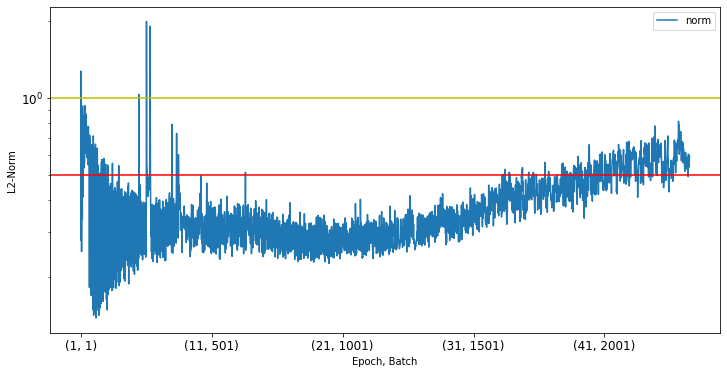

In [25]:
import matplotlib.pyplot as plt
df_grads = pd.read_csv('../model_data/gradients_2_1_512_0pt4.csv', index_col = [0, 1])
df_grads.plot(y = 'norm', figsize = (12, 6), logy = True, xlabel = 'Epoch, Batch', \
             ylabel = 'L2-Norm', fontsize = 12)
plt.axhline(1, color = 'y')
plt.axhline(0.5, color = 'r')

In the above plot (note the logscale on the y-axis), we have added a line corresponding to the suggested clipnorm value of 1.0. We can see that on only two occasions in early training does the L2-norm exceed this value. It is possible that the norm for the final batch would have exploded. To get a better idea, one could re-run with a smaller batch size. However, there is no way to know how much we would have to decrease the batch size to see such an effect. Since lowering the batch size would also increase the run-time, we will halt the exploration here. Our plan is now to train models with clipnorm = 1.0 (line in <font color='yellow'>yellow</font>) and 0.5 (line in <font color='red'>red</font>). The latter should have an effect on the late-stage training.

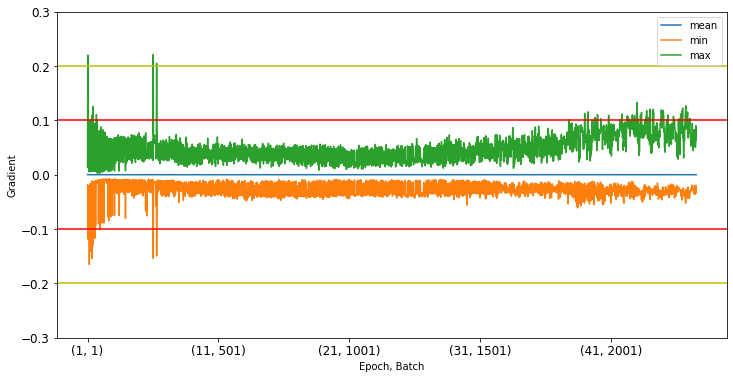

In [26]:
df_grads.plot(y = ['mean', 'min', 'max'], xlabel = 'Epoch, Batch', \
             ylabel = 'Gradient', figsize = (12, 6), fontsize = 12, ylim = [-.3, .3])
plt.axhline(0.2, color = 'y')
plt.axhline(-0.2, color = 'y')
plt.axhline(0.1, color = 'r')
plt.axhline(-0.1, color = 'r')

From this plot, we can see that the mean says near zero while the min is largest in early training, and the max is largest in late training (though both get pretty large). However, neither really approach the level of 0.5 (a clipvalue of 0.5 was used in the [blog post](https://machinelearningmastery.com/how-to-avoid-exploding-gradients-in-neural-networks-with-gradient-clipping/)). Perhaps such a value would delay the NaN failure in the final batch. However, from the plot, I think a clipvalue of 0.2 (line in <font color='yellow'>yellow</font>) is a better start. And then, we can reduce it to 0.1 (line in <font color='red'>red</font>) which should certainly affect the late training.

In [27]:
train_lstm_model(clipnorm = 1.0)

Train on 25256 samples, validate on 10824 samples
Epoch 1/150
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.

Epoch 00001: val_loss improved from inf to 0.16327, saving model to ../models/best_maestro_model_2_1_512_0pt4_cn_1pt0.h5
25256/25256 - 161s - loss: 0.2239 - f1_score_mod: 0.0138 - recall_mod: 0.0227 - precision_mod: 0.0997 - dur_error: 1.0557 - maestro_dur_loss: 0.0528 - val_loss: 0.1633 - val_f1_score_mod: 0.0000e+00 - val_recall_mod: 0.0000e+00 - val_precision_mod: 0.0000e+00 - val_dur_error: 0.8993 - val_maestro_dur_loss: 0.0450
Epoch 2/150

Epoch 00002: val_loss improved from 0.16327 to 0.15037, saving model to ../models/best_maestro_model_2_1_512_0pt4_cn_1pt0.h5
25256/25256 - 145s - loss: 0.1623 - f1_score_mod: 0.0022 - recall_mod: 0.0011 - precision_mod: 0.2901 - dur_error: 0.7105 - maestro_dur_loss: 0.0355 - val_loss: 0.1504 - val_f1_score_mod: 0.0265 - val_recall_mod: 0.0137 - val_precision_mod: 0.555

Epoch 20/150

Epoch 00020: val_loss improved from 0.10695 to 0.10474, saving model to ../models/best_maestro_model_2_1_512_0pt4_cn_1pt0.h5
25256/25256 - 134s - loss: 0.1163 - f1_score_mod: 0.2542 - recall_mod: 0.1551 - precision_mod: 0.7162 - dur_error: 0.4486 - maestro_dur_loss: 0.0224 - val_loss: 0.1047 - val_f1_score_mod: 0.2565 - val_recall_mod: 0.1559 - val_precision_mod: 0.7255 - val_dur_error: 0.2941 - val_maestro_dur_loss: 0.0147
Epoch 21/150

Epoch 00021: val_loss did not improve from 0.10474
25256/25256 - 132s - loss: 0.1151 - f1_score_mod: 0.2628 - recall_mod: 0.1612 - precision_mod: 0.7159 - dur_error: 0.4424 - maestro_dur_loss: 0.0221 - val_loss: 0.1064 - val_f1_score_mod: 0.2538 - val_recall_mod: 0.1534 - val_precision_mod: 0.7450 - val_dur_error: 0.3287 - val_maestro_dur_loss: 0.0164
Epoch 22/150

Epoch 00022: val_loss did not improve from 0.10474
25256/25256 - 133s - loss: 0.1142 - f1_score_mod: 0.2712 - recall_mod: 0.1676 - precision_mod: 0.7178 - dur_error: 0.4376 - m

Epoch 41/150

Epoch 00041: val_loss improved from 0.09570 to 0.09532, saving model to ../models/best_maestro_model_2_1_512_0pt4_cn_1pt0.h5
25256/25256 - 133s - loss: 0.0982 - f1_score_mod: 0.3955 - recall_mod: 0.2701 - precision_mod: 0.7418 - dur_error: 0.3862 - maestro_dur_loss: 0.0193 - val_loss: 0.0953 - val_f1_score_mod: 0.3782 - val_recall_mod: 0.2566 - val_precision_mod: 0.7212 - val_dur_error: 0.2789 - val_maestro_dur_loss: 0.0139
Epoch 42/150

Epoch 00042: val_loss did not improve from 0.09532
25256/25256 - 133s - loss: 0.0979 - f1_score_mod: 0.3980 - recall_mod: 0.2723 - precision_mod: 0.7427 - dur_error: 0.3858 - maestro_dur_loss: 0.0193 - val_loss: 0.0984 - val_f1_score_mod: 0.3797 - val_recall_mod: 0.2586 - val_precision_mod: 0.7176 - val_dur_error: 0.3403 - val_maestro_dur_loss: 0.0170
Epoch 43/150

Epoch 00043: val_loss did not improve from 0.09532
25256/25256 - 135s - loss: 0.0966 - f1_score_mod: 0.4041 - recall_mod: 0.2777 - precision_mod: 0.7447 - dur_error: 0.3770 - m

This model performed about as well on the validation set as the model with half the default learning rate, in fewer epochs. However, it failed at a higher training loss. Let's now try with clipnorm = 0.5

In [28]:
train_lstm_model(clipnorm = 0.5)

Train on 25256 samples, validate on 10824 samples
Epoch 1/150

Epoch 00001: val_loss improved from inf to 0.15157, saving model to ../models/best_maestro_model_2_1_512_0pt4_cn_0pt5.h5
25256/25256 - 135s - loss: 0.2211 - f1_score_mod: 0.0137 - recall_mod: 0.0218 - precision_mod: 0.1212 - dur_error: 1.0112 - maestro_dur_loss: 0.0506 - val_loss: 0.1516 - val_f1_score_mod: 0.0000e+00 - val_recall_mod: 0.0000e+00 - val_precision_mod: 0.0000e+00 - val_dur_error: 0.6820 - val_maestro_dur_loss: 0.0341
Epoch 2/150

Epoch 00002: val_loss improved from 0.15157 to 0.14176, saving model to ../models/best_maestro_model_2_1_512_0pt4_cn_0pt5.h5
25256/25256 - 134s - loss: 0.1616 - f1_score_mod: 0.0021 - recall_mod: 0.0011 - precision_mod: 0.2882 - dur_error: 0.7003 - maestro_dur_loss: 0.0350 - val_loss: 0.1418 - val_f1_score_mod: 0.0000e+00 - val_recall_mod: 0.0000e+00 - val_precision_mod: 0.0000e+00 - val_dur_error: 0.5354 - val_maestro_dur_loss: 0.0268
Epoch 3/150

Epoch 00003: val_loss did not impro

Epoch 21/150

Epoch 00021: val_loss did not improve from 0.10736
25256/25256 - 132s - loss: 0.1153 - f1_score_mod: 0.2558 - recall_mod: 0.1560 - precision_mod: 0.7171 - dur_error: 0.4384 - maestro_dur_loss: 0.0219 - val_loss: 0.1086 - val_f1_score_mod: 0.2634 - val_recall_mod: 0.1615 - val_precision_mod: 0.7187 - val_dur_error: 0.3604 - val_maestro_dur_loss: 0.0180
Epoch 22/150

Epoch 00022: val_loss improved from 0.10736 to 0.10434, saving model to ../models/best_maestro_model_2_1_512_0pt4_cn_0pt5.h5
25256/25256 - 132s - loss: 0.1145 - f1_score_mod: 0.2641 - recall_mod: 0.1622 - precision_mod: 0.7178 - dur_error: 0.4376 - maestro_dur_loss: 0.0219 - val_loss: 0.1043 - val_f1_score_mod: 0.2683 - val_recall_mod: 0.1646 - val_precision_mod: 0.7312 - val_dur_error: 0.3008 - val_maestro_dur_loss: 0.0150
Epoch 23/150

Epoch 00023: val_loss improved from 0.10434 to 0.10330, saving model to ../models/best_maestro_model_2_1_512_0pt4_cn_0pt5.h5
25256/25256 - 132s - loss: 0.1135 - f1_score_mod: 0

23040/25256 - 105s - loss: nan - f1_score_mod: 0.3976 - recall_mod: 0.2718 - precision_mod: 0.7434 - dur_error: 0.3811 - maestro_dur_loss: 0.0191


In [29]:
train_lstm_model(clipvalue = 0.2)

Train on 25256 samples, validate on 10824 samples
Epoch 1/150

Epoch 00001: val_loss improved from inf to 0.14660, saving model to ../models/best_maestro_model_2_1_512_0pt4_cv_0pt2.h5
25256/25256 - 135s - loss: 0.2179 - f1_score_mod: 0.0149 - recall_mod: 0.0237 - precision_mod: 0.1051 - dur_error: 0.9675 - maestro_dur_loss: 0.0484 - val_loss: 0.1466 - val_f1_score_mod: 0.0000e+00 - val_recall_mod: 0.0000e+00 - val_precision_mod: 0.0000e+00 - val_dur_error: 0.5633 - val_maestro_dur_loss: 0.0282
Epoch 2/150

Epoch 00002: val_loss improved from 0.14660 to 0.14057, saving model to ../models/best_maestro_model_2_1_512_0pt4_cv_0pt2.h5
25256/25256 - 132s - loss: 0.1613 - f1_score_mod: 0.0052 - recall_mod: 0.0027 - precision_mod: 0.2944 - dur_error: 0.6947 - maestro_dur_loss: 0.0347 - val_loss: 0.1406 - val_f1_score_mod: 0.0052 - val_recall_mod: 0.0026 - val_precision_mod: 0.6562 - val_dur_error: 0.5456 - val_maestro_dur_loss: 0.0273
Epoch 3/150

Epoch 00003: val_loss improved from 0.14057 to 

Epoch 21/150

Epoch 00021: val_loss did not improve from 0.10767
25256/25256 - 131s - loss: 0.1176 - f1_score_mod: 0.2373 - recall_mod: 0.1428 - precision_mod: 0.7118 - dur_error: 0.4486 - maestro_dur_loss: 0.0224 - val_loss: 0.1102 - val_f1_score_mod: 0.2364 - val_recall_mod: 0.1414 - val_precision_mod: 0.7314 - val_dur_error: 0.3700 - val_maestro_dur_loss: 0.0185
Epoch 22/150

Epoch 00022: val_loss improved from 0.10767 to 0.10514, saving model to ../models/best_maestro_model_2_1_512_0pt4_cv_0pt2.h5
25256/25256 - 132s - loss: 0.1167 - f1_score_mod: 0.2456 - recall_mod: 0.1489 - precision_mod: 0.7123 - dur_error: 0.4455 - maestro_dur_loss: 0.0223 - val_loss: 0.1051 - val_f1_score_mod: 0.2462 - val_recall_mod: 0.1483 - val_precision_mod: 0.7321 - val_dur_error: 0.2862 - val_maestro_dur_loss: 0.0143
Epoch 23/150

Epoch 00023: val_loss did not improve from 0.10514
25256/25256 - 131s - loss: 0.1155 - f1_score_mod: 0.2533 - recall_mod: 0.1544 - precision_mod: 0.7143 - dur_error: 0.4391 - m

Epoch 42/150

Epoch 00042: val_loss improved from 0.09711 to 0.09568, saving model to ../models/best_maestro_model_2_1_512_0pt4_cv_0pt2.h5
25256/25256 - 133s - loss: 0.0996 - f1_score_mod: 0.3811 - recall_mod: 0.2573 - precision_mod: 0.7401 - dur_error: 0.3859 - maestro_dur_loss: 0.0193 - val_loss: 0.0957 - val_f1_score_mod: 0.3727 - val_recall_mod: 0.2528 - val_precision_mod: 0.7142 - val_dur_error: 0.2645 - val_maestro_dur_loss: 0.0132
Epoch 43/150

Epoch 00043: val_loss improved from 0.09568 to 0.09476, saving model to ../models/best_maestro_model_2_1_512_0pt4_cv_0pt2.h5
25256/25256 - 132s - loss: 0.0986 - f1_score_mod: 0.3897 - recall_mod: 0.2645 - precision_mod: 0.7416 - dur_error: 0.3828 - maestro_dur_loss: 0.0191 - val_loss: 0.0948 - val_f1_score_mod: 0.3662 - val_recall_mod: 0.2432 - val_precision_mod: 0.7473 - val_dur_error: 0.2635 - val_maestro_dur_loss: 0.0132
Epoch 44/150

Epoch 00044: val_loss did not improve from 0.09476
25256/25256 - 135s - loss: 0.0976 - f1_score_mod: 0

Better than the base model, but not as effective as clipnorm = 1.0.

In [30]:
train_lstm_model(clipvalue = 0.1)

Train on 25256 samples, validate on 10824 samples
Epoch 1/150

Epoch 00001: val_loss improved from inf to 0.15061, saving model to ../models/best_maestro_model_2_1_512_0pt4_cv_0pt1.h5
25256/25256 - 137s - loss: 0.2190 - f1_score_mod: 0.0156 - recall_mod: 0.0250 - precision_mod: 0.1081 - dur_error: 0.9839 - maestro_dur_loss: 0.0492 - val_loss: 0.1506 - val_f1_score_mod: 0.0000e+00 - val_recall_mod: 0.0000e+00 - val_precision_mod: 0.0000e+00 - val_dur_error: 0.6511 - val_maestro_dur_loss: 0.0326
Epoch 2/150

Epoch 00002: val_loss improved from 0.15061 to 0.14876, saving model to ../models/best_maestro_model_2_1_512_0pt4_cv_0pt1.h5
25256/25256 - 134s - loss: 0.1617 - f1_score_mod: 0.0030 - recall_mod: 0.0015 - precision_mod: 0.2526 - dur_error: 0.6876 - maestro_dur_loss: 0.0344 - val_loss: 0.1488 - val_f1_score_mod: 0.0064 - val_recall_mod: 0.0032 - val_precision_mod: 0.6569 - val_dur_error: 0.6038 - val_maestro_dur_loss: 0.0302
Epoch 3/150

Epoch 00003: val_loss improved from 0.14876 to 

Epoch 21/150

Epoch 00021: val_loss did not improve from 0.10884
25256/25256 - 132s - loss: 0.1181 - f1_score_mod: 0.2329 - recall_mod: 0.1398 - precision_mod: 0.7064 - dur_error: 0.4514 - maestro_dur_loss: 0.0226 - val_loss: 0.1132 - val_f1_score_mod: 0.2402 - val_recall_mod: 0.1452 - val_precision_mod: 0.7025 - val_dur_error: 0.4088 - val_maestro_dur_loss: 0.0204
Epoch 22/150

Epoch 00022: val_loss did not improve from 0.10884
25256/25256 - 133s - loss: 0.1179 - f1_score_mod: 0.2363 - recall_mod: 0.1425 - precision_mod: 0.7079 - dur_error: 0.4531 - maestro_dur_loss: 0.0227 - val_loss: 0.1136 - val_f1_score_mod: 0.2499 - val_recall_mod: 0.1523 - val_precision_mod: 0.7016 - val_dur_error: 0.4439 - val_maestro_dur_loss: 0.0222
Epoch 23/150

Epoch 00023: val_loss did not improve from 0.10884
25256/25256 - 133s - loss: 0.1167 - f1_score_mod: 0.2471 - recall_mod: 0.1497 - precision_mod: 0.7156 - dur_error: 0.4477 - maestro_dur_loss: 0.0224 - val_loss: 0.1148 - val_f1_score_mod: 0.2605 - va

Epoch 42/150
Batch 22: Invalid loss, terminating training
11776/25256 - 54s - loss: nan - f1_score_mod: 0.3739 - recall_mod: 0.2507 - precision_mod: 0.7398 - dur_error: 0.3887 - maestro_dur_loss: 0.0194


Surprisingly, not as effective in delaying failure as clipvalue = 0.2. The best results were achieved with clipnorm = 1.0 and lr = 5e-4. Let's now combine these settings.

Check out visualize_performance.ipynb (Figures 1 and 2) for a comparison of the model training between those run so far (excluding the clipvalue runs since it appears setting clipnorm is a better approach.
Next, let's combine the our best clipnorm value (0.5) with an lr of 5e-4.

In [31]:
train_lstm_model(lr = 0.0005, clipnorm = 1.0)

Train on 25256 samples, validate on 10824 samples
Epoch 1/150

Epoch 00001: val_loss improved from inf to 0.14153, saving model to ../models/best_maestro_model_2_1_512_0pt4_lr_5e-04_cn_1pt0.h5
25256/25256 - 142s - loss: 0.2409 - f1_score_mod: 0.0244 - recall_mod: 0.0316 - precision_mod: 0.0844 - dur_error: 1.0069 - maestro_dur_loss: 0.0503 - val_loss: 0.1415 - val_f1_score_mod: 0.0000e+00 - val_recall_mod: 0.0000e+00 - val_precision_mod: 0.0000e+00 - val_dur_error: 0.4365 - val_maestro_dur_loss: 0.0218
Epoch 2/150

Epoch 00002: val_loss did not improve from 0.14153
25256/25256 - 135s - loss: 0.1682 - f1_score_mod: 0.0046 - recall_mod: 0.0023 - precision_mod: 0.2031 - dur_error: 0.7270 - maestro_dur_loss: 0.0363 - val_loss: 0.1430 - val_f1_score_mod: 0.0000e+00 - val_recall_mod: 0.0000e+00 - val_precision_mod: 0.0000e+00 - val_dur_error: 0.5235 - val_maestro_dur_loss: 0.0262
Epoch 3/150

Epoch 00003: val_loss improved from 0.14153 to 0.13727, saving model to ../models/best_maestro_model

Epoch 21/150

Epoch 00021: val_loss did not improve from 0.10892
25256/25256 - 132s - loss: 0.1195 - f1_score_mod: 0.2112 - recall_mod: 0.1244 - precision_mod: 0.7061 - dur_error: 0.4347 - maestro_dur_loss: 0.0217 - val_loss: 0.1146 - val_f1_score_mod: 0.2087 - val_recall_mod: 0.1232 - val_precision_mod: 0.6986 - val_dur_error: 0.4138 - val_maestro_dur_loss: 0.0207
Epoch 22/150

Epoch 00022: val_loss improved from 0.10892 to 0.10828, saving model to ../models/best_maestro_model_2_1_512_0pt4_lr_5e-04_cn_1pt0.h5
25256/25256 - 134s - loss: 0.1192 - f1_score_mod: 0.2169 - recall_mod: 0.1286 - precision_mod: 0.7015 - dur_error: 0.4375 - maestro_dur_loss: 0.0219 - val_loss: 0.1083 - val_f1_score_mod: 0.2303 - val_recall_mod: 0.1376 - val_precision_mod: 0.7296 - val_dur_error: 0.3095 - val_maestro_dur_loss: 0.0155
Epoch 23/150

Epoch 00023: val_loss did not improve from 0.10828
25256/25256 - 133s - loss: 0.1182 - f1_score_mod: 0.2227 - recall_mod: 0.1322 - precision_mod: 0.7096 - dur_error: 0

Epoch 42/150

Epoch 00042: val_loss improved from 0.10149 to 0.10030, saving model to ../models/best_maestro_model_2_1_512_0pt4_lr_5e-04_cn_1pt0.h5
25256/25256 - 135s - loss: 0.1068 - f1_score_mod: 0.3245 - recall_mod: 0.2085 - precision_mod: 0.7350 - dur_error: 0.3874 - maestro_dur_loss: 0.0194 - val_loss: 0.1003 - val_f1_score_mod: 0.3145 - val_recall_mod: 0.2009 - val_precision_mod: 0.7321 - val_dur_error: 0.2791 - val_maestro_dur_loss: 0.0140
Epoch 43/150

Epoch 00043: val_loss improved from 0.10030 to 0.10011, saving model to ../models/best_maestro_model_2_1_512_0pt4_lr_5e-04_cn_1pt0.h5
25256/25256 - 134s - loss: 0.1066 - f1_score_mod: 0.3284 - recall_mod: 0.2114 - precision_mod: 0.7412 - dur_error: 0.3897 - maestro_dur_loss: 0.0195 - val_loss: 0.1001 - val_f1_score_mod: 0.3302 - val_recall_mod: 0.2159 - val_precision_mod: 0.7064 - val_dur_error: 0.2736 - val_maestro_dur_loss: 0.0137
Epoch 44/150

Epoch 00044: val_loss did not improve from 0.10011
25256/25256 - 134s - loss: 0.1059


Epoch 00062: val_loss did not improve from 0.09529
25256/25256 - 133s - loss: 0.0960 - f1_score_mod: 0.4081 - recall_mod: 0.2797 - precision_mod: 0.7566 - dur_error: 0.3591 - maestro_dur_loss: 0.0180 - val_loss: 0.0983 - val_f1_score_mod: 0.3937 - val_recall_mod: 0.2750 - val_precision_mod: 0.6949 - val_dur_error: 0.3245 - val_maestro_dur_loss: 0.0162
Epoch 63/150

Epoch 00063: val_loss did not improve from 0.09529
25256/25256 - 133s - loss: 0.0957 - f1_score_mod: 0.4127 - recall_mod: 0.2849 - precision_mod: 0.7523 - dur_error: 0.3592 - maestro_dur_loss: 0.0180 - val_loss: 0.0954 - val_f1_score_mod: 0.3871 - val_recall_mod: 0.2672 - val_precision_mod: 0.7060 - val_dur_error: 0.2600 - val_maestro_dur_loss: 0.0130
Epoch 64/150

Epoch 00064: val_loss did not improve from 0.09529
25256/25256 - 135s - loss: 0.0951 - f1_score_mod: 0.4176 - recall_mod: 0.2894 - precision_mod: 0.7520 - dur_error: 0.3575 - maestro_dur_loss: 0.0179 - val_loss: 0.0986 - val_f1_score_mod: 0.3871 - val_recall_mod:

23040/25256 - 107s - loss: nan - f1_score_mod: 0.5022 - recall_mod: 0.3764 - precision_mod: 0.7558 - dur_error: 0.3390 - maestro_dur_loss: 0.0170


In [32]:
train_lstm_model(lr = 0.0005, clipnorm = 1.0, dropout_rate = 0.3)

Train on 25256 samples, validate on 10824 samples
Epoch 1/150

Epoch 00001: val_loss improved from inf to 0.14012, saving model to ../models/best_maestro_model_2_1_512_0pt3_lr_5e-04_cn_1pt0.h5
25256/25256 - 138s - loss: 0.2305 - f1_score_mod: 0.0192 - recall_mod: 0.0292 - precision_mod: 0.0944 - dur_error: 0.9799 - maestro_dur_loss: 0.0490 - val_loss: 0.1401 - val_f1_score_mod: 0.0000e+00 - val_recall_mod: 0.0000e+00 - val_precision_mod: 0.0000e+00 - val_dur_error: 0.4328 - val_maestro_dur_loss: 0.0216
Epoch 2/150

Epoch 00002: val_loss did not improve from 0.14012
25256/25256 - 133s - loss: 0.1631 - f1_score_mod: 0.0032 - recall_mod: 0.0016 - precision_mod: 0.2294 - dur_error: 0.6816 - maestro_dur_loss: 0.0341 - val_loss: 0.1433 - val_f1_score_mod: 0.0000e+00 - val_recall_mod: 0.0000e+00 - val_precision_mod: 0.0000e+00 - val_dur_error: 0.5495 - val_maestro_dur_loss: 0.0275
Epoch 3/150

Epoch 00003: val_loss did not improve from 0.14012
25256/25256 - 133s - loss: 0.1528 - f1_score_mod:

Epoch 21/150

Epoch 00021: val_loss did not improve from 0.11153
25256/25256 - 133s - loss: 0.1188 - f1_score_mod: 0.2153 - recall_mod: 0.1273 - precision_mod: 0.7082 - dur_error: 0.4286 - maestro_dur_loss: 0.0214 - val_loss: 0.1162 - val_f1_score_mod: 0.2012 - val_recall_mod: 0.1172 - val_precision_mod: 0.7150 - val_dur_error: 0.4416 - val_maestro_dur_loss: 0.0221
Epoch 22/150

Epoch 00022: val_loss improved from 0.11153 to 0.11119, saving model to ../models/best_maestro_model_2_1_512_0pt3_lr_5e-04_cn_1pt0.h5
25256/25256 - 134s - loss: 0.1180 - f1_score_mod: 0.2199 - recall_mod: 0.1306 - precision_mod: 0.7061 - dur_error: 0.4255 - maestro_dur_loss: 0.0213 - val_loss: 0.1112 - val_f1_score_mod: 0.2259 - val_recall_mod: 0.1353 - val_precision_mod: 0.6979 - val_dur_error: 0.3553 - val_maestro_dur_loss: 0.0178
Epoch 23/150

Epoch 00023: val_loss did not improve from 0.11119
25256/25256 - 134s - loss: 0.1168 - f1_score_mod: 0.2304 - recall_mod: 0.1376 - precision_mod: 0.7169 - dur_error: 0

Epoch 42/150

Epoch 00042: val_loss did not improve from 0.10055
25256/25256 - 134s - loss: 0.1029 - f1_score_mod: 0.3504 - recall_mod: 0.2293 - precision_mod: 0.7460 - dur_error: 0.3647 - maestro_dur_loss: 0.0182 - val_loss: 0.1068 - val_f1_score_mod: 0.3404 - val_recall_mod: 0.2249 - val_precision_mod: 0.7053 - val_dur_error: 0.4112 - val_maestro_dur_loss: 0.0206
Epoch 43/150

Epoch 00043: val_loss improved from 0.10055 to 0.09943, saving model to ../models/best_maestro_model_2_1_512_0pt3_lr_5e-04_cn_1pt0.h5
25256/25256 - 134s - loss: 0.1021 - f1_score_mod: 0.3566 - recall_mod: 0.2339 - precision_mod: 0.7529 - dur_error: 0.3623 - maestro_dur_loss: 0.0181 - val_loss: 0.0994 - val_f1_score_mod: 0.3451 - val_recall_mod: 0.2275 - val_precision_mod: 0.7196 - val_dur_error: 0.2749 - val_maestro_dur_loss: 0.0137
Epoch 44/150

Epoch 00044: val_loss did not improve from 0.09943
25256/25256 - 134s - loss: 0.1014 - f1_score_mod: 0.3605 - recall_mod: 0.2374 - precision_mod: 0.7512 - dur_error: 0

Epoch 63/150

Epoch 00063: val_loss improved from 0.09438 to 0.09389, saving model to ../models/best_maestro_model_2_1_512_0pt3_lr_5e-04_cn_1pt0.h5
25256/25256 - 134s - loss: 0.0887 - f1_score_mod: 0.4641 - recall_mod: 0.3338 - precision_mod: 0.7629 - dur_error: 0.3314 - maestro_dur_loss: 0.0166 - val_loss: 0.0939 - val_f1_score_mod: 0.4094 - val_recall_mod: 0.2931 - val_precision_mod: 0.6810 - val_dur_error: 0.2496 - val_maestro_dur_loss: 0.0125
Epoch 64/150

Epoch 00064: val_loss did not improve from 0.09389
25256/25256 - 133s - loss: 0.0883 - f1_score_mod: 0.4658 - recall_mod: 0.3357 - precision_mod: 0.7619 - dur_error: 0.3317 - maestro_dur_loss: 0.0166 - val_loss: 0.0949 - val_f1_score_mod: 0.4156 - val_recall_mod: 0.2977 - val_precision_mod: 0.6949 - val_dur_error: 0.2798 - val_maestro_dur_loss: 0.0140
Epoch 65/150

Epoch 00065: val_loss improved from 0.09389 to 0.09333, saving model to ../models/best_maestro_model_2_1_512_0pt3_lr_5e-04_cn_1pt0.h5
25256/25256 - 133s - loss: 0.0875

Epoch 85/150

Epoch 00085: val_loss did not improve from 0.09281
25256/25256 - 134s - loss: 0.0730 - f1_score_mod: 0.5869 - recall_mod: 0.4701 - precision_mod: 0.7817 - dur_error: 0.3059 - maestro_dur_loss: 0.0153 - val_loss: 0.0941 - val_f1_score_mod: 0.4699 - val_recall_mod: 0.3688 - val_precision_mod: 0.6482 - val_dur_error: 0.2536 - val_maestro_dur_loss: 0.0127
Epoch 86/150

Epoch 00086: val_loss did not improve from 0.09281
25256/25256 - 134s - loss: 0.0727 - f1_score_mod: 0.5904 - recall_mod: 0.4754 - precision_mod: 0.7797 - dur_error: 0.3055 - maestro_dur_loss: 0.0153 - val_loss: 0.0983 - val_f1_score_mod: 0.4758 - val_recall_mod: 0.3760 - val_precision_mod: 0.6486 - val_dur_error: 0.3536 - val_maestro_dur_loss: 0.0177
Epoch 87/150

Epoch 00087: val_loss did not improve from 0.09281
25256/25256 - 133s - loss: 0.0721 - f1_score_mod: 0.5957 - recall_mod: 0.4815 - precision_mod: 0.7816 - dur_error: 0.3092 - maestro_dur_loss: 0.0155 - val_loss: 0.0954 - val_f1_score_mod: 0.4797 - va

It certainly does delay failure until the training loss is significantly lower. However, since dropout is designed to combat overfitting, lowering it increases overfitting causing the validation loss to remain relatively high. It now makes sense to increase dropout_rate since lowering it did not have a favorable effect.

In [33]:
train_lstm_model(lr = 0.0005, clipnorm = 1.0, dropout_rate = 0.5)

Train on 25256 samples, validate on 10824 samples
Epoch 1/150

Epoch 00001: val_loss improved from inf to 0.16498, saving model to ../models/best_maestro_model_2_1_512_0pt5_lr_5e-04_cn_1pt0.h5
25256/25256 - 178s - loss: 0.2584 - f1_score_mod: 0.0313 - recall_mod: 0.0438 - precision_mod: 0.0693 - dur_error: 1.0616 - maestro_dur_loss: 0.0531 - val_loss: 0.1650 - val_f1_score_mod: 0.0000e+00 - val_recall_mod: 0.0000e+00 - val_precision_mod: 0.0000e+00 - val_dur_error: 0.9011 - val_maestro_dur_loss: 0.0451
Epoch 2/150

Epoch 00002: val_loss improved from 0.16498 to 0.15863, saving model to ../models/best_maestro_model_2_1_512_0pt5_lr_5e-04_cn_1pt0.h5
25256/25256 - 172s - loss: 0.1751 - f1_score_mod: 0.0075 - recall_mod: 0.0039 - precision_mod: 0.1424 - dur_error: 0.7806 - maestro_dur_loss: 0.0390 - val_loss: 0.1586 - val_f1_score_mod: 0.0000e+00 - val_recall_mod: 0.0000e+00 - val_precision_mod: 0.0000e+00 - val_dur_error: 0.5895 - val_maestro_dur_loss: 0.0295
Epoch 3/150

Epoch 00003: val_

Epoch 21/150

Epoch 00021: val_loss improved from 0.11346 to 0.10987, saving model to ../models/best_maestro_model_2_1_512_0pt5_lr_5e-04_cn_1pt0.h5
25256/25256 - 172s - loss: 0.1246 - f1_score_mod: 0.1622 - recall_mod: 0.0924 - precision_mod: 0.6741 - dur_error: 0.4601 - maestro_dur_loss: 0.0230 - val_loss: 0.1099 - val_f1_score_mod: 0.1726 - val_recall_mod: 0.0982 - val_precision_mod: 0.7278 - val_dur_error: 0.2901 - val_maestro_dur_loss: 0.0145
Epoch 22/150

Epoch 00022: val_loss did not improve from 0.10987
25256/25256 - 169s - loss: 0.1240 - f1_score_mod: 0.1682 - recall_mod: 0.0961 - precision_mod: 0.6842 - dur_error: 0.4601 - maestro_dur_loss: 0.0230 - val_loss: 0.1169 - val_f1_score_mod: 0.1831 - val_recall_mod: 0.1049 - val_precision_mod: 0.7293 - val_dur_error: 0.4274 - val_maestro_dur_loss: 0.0214
Epoch 23/150

Epoch 00023: val_loss did not improve from 0.10987
25256/25256 - 170s - loss: 0.1234 - f1_score_mod: 0.1758 - recall_mod: 0.1012 - precision_mod: 0.6846 - dur_error: 0

Epoch 42/150

Epoch 00042: val_loss improved from 0.10424 to 0.10325, saving model to ../models/best_maestro_model_2_1_512_0pt5_lr_5e-04_cn_1pt0.h5
25256/25256 - 184s - loss: 0.1137 - f1_score_mod: 0.2577 - recall_mod: 0.1573 - precision_mod: 0.7200 - dur_error: 0.4170 - maestro_dur_loss: 0.0209 - val_loss: 0.1032 - val_f1_score_mod: 0.2648 - val_recall_mod: 0.1613 - val_precision_mod: 0.7426 - val_dur_error: 0.2715 - val_maestro_dur_loss: 0.0136
Epoch 43/150

Epoch 00043: val_loss did not improve from 0.10325
25256/25256 - 179s - loss: 0.1133 - f1_score_mod: 0.2614 - recall_mod: 0.1599 - precision_mod: 0.7212 - dur_error: 0.4114 - maestro_dur_loss: 0.0206 - val_loss: 0.1067 - val_f1_score_mod: 0.2824 - val_recall_mod: 0.1754 - val_precision_mod: 0.7279 - val_dur_error: 0.3511 - val_maestro_dur_loss: 0.0176
Epoch 44/150

Epoch 00044: val_loss did not improve from 0.10325
25256/25256 - 174s - loss: 0.1129 - f1_score_mod: 0.2668 - recall_mod: 0.1642 - precision_mod: 0.7207 - dur_error: 0

Epoch 63/150

Epoch 00063: val_loss did not improve from 0.09870
25256/25256 - 134s - loss: 0.1044 - f1_score_mod: 0.3384 - recall_mod: 0.2205 - precision_mod: 0.7308 - dur_error: 0.3861 - maestro_dur_loss: 0.0193 - val_loss: 0.1005 - val_f1_score_mod: 0.3423 - val_recall_mod: 0.2241 - val_precision_mod: 0.7297 - val_dur_error: 0.3077 - val_maestro_dur_loss: 0.0154
Epoch 64/150

Epoch 00064: val_loss improved from 0.09870 to 0.09863, saving model to ../models/best_maestro_model_2_1_512_0pt5_lr_5e-04_cn_1pt0.h5
25256/25256 - 134s - loss: 0.1041 - f1_score_mod: 0.3410 - recall_mod: 0.2221 - precision_mod: 0.7385 - dur_error: 0.3867 - maestro_dur_loss: 0.0193 - val_loss: 0.0986 - val_f1_score_mod: 0.3419 - val_recall_mod: 0.2246 - val_precision_mod: 0.7219 - val_dur_error: 0.2755 - val_maestro_dur_loss: 0.0138
Epoch 65/150

Epoch 00065: val_loss improved from 0.09863 to 0.09827, saving model to ../models/best_maestro_model_2_1_512_0pt5_lr_5e-04_cn_1pt0.h5
25256/25256 - 134s - loss: 0.1036

The training here does a better job of generalizing to the validation set (as expected) but causes an earlier failure (in terms of training loss). For a visual comparison of performance depending on the dropout_rate, see Figures 5 and 6 from visualize_performance.ipynb.

Our best performing model is ../models/best_maestro_model_2_1_512_0pt4_lr_5e-04_cn_1pt0.h5. See the final section in visualize_performance.ipynb for an in-depth visual analysis of the performance of this model.